In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.dates as mdates

PATH_TO_KEY="./tutorialGBQKey.json"
credentials = service_account.Credentials.from_service_account_file(PATH_TO_KEY)
client = bigquery.Client(credentials= credentials)

In [3]:
# Define the pool address (USDC-ETH pool at 0.3% fee)
POOL_ADDRESS = "0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8"

# Define the SQL query.
# Note the additional condition:
#    AND block_timestamp >= "2024-08-01"
# which ensures that we only fetch data starting from August 2024.
query = '''
SELECT
  block_number,
  block_timestamp,
  log_index,
  transaction_index,
  CONCAT('0x',(CAST(SUBSTRING(Data, 3, 64) as string))) as amount0,
  CONCAT('0x',(CAST(SUBSTRING(Data, 67, 64) as string))) as amount1,
  CONCAT('0x',(CAST(SUBSTRING(Data, 195, 64) as string))) as liquidity,
IF
  ((CAST(CONCAT('0x',(CAST(SUBSTRING(DATA, 317, 16) AS string))) AS int)) > CAST('0xf00000' AS int),
     (CAST(CONCAT('0x',(CAST(SUBSTRING(DATA, 317, 16) AS string))) AS int)) - CAST('0xffffff' AS int),
     CAST(CONCAT('0x',(CAST(SUBSTRING(DATA, 317, 16) AS string))) AS int)) AS tick
FROM
  `bigquery-public-data.crypto_ethereum.logs`
WHERE
  DATA != ""
  AND transaction_hash != ""
  AND block_timestamp >= "2024-08-01"
  AND address = lower("{}")
  AND (CAST(SUBSTRING(DATA, 259, 64) AS string)) != ''
ORDER BY
  block_timestamp ASC, transaction_index
'''.format(POOL_ADDRESS)

print("⏰ Performing the query")
try:
    df = client.query(query).to_dataframe()
    print("🟢 Query completed successfully!")
except Exception as e:
    print("🟠 There was an issue querying the data!")
    print(e)
    exit()

⏰ Performing the query
🟢 Query completed successfully!


In [4]:
df.to_csv('raw_pool_data.csv', index=False)
df.head()

,block_number,block_timestamp,log_index,transaction_index,amount0,amount1,liquidity,tick
0,20430121,2024-08-01 00:29:47+00:00,2,0,0xffffffffffffffffffffffffffffffffffffffffffff...,0x00000000000000000000000000000000000000000000...,0x00000000000000000000000000000000000000000000...,195512
1,20430122,2024-08-01 00:29:59+00:00,93,97,0xffffffffffffffffffffffffffffffffffffffffffff...,0x00000000000000000000000000000000000000000000...,0x00000000000000000000000000000000000000000000...,195516
2,20430123,2024-08-01 00:30:11+00:00,55,6,0xffffffffffffffffffffffffffffffffffffffffffff...,0x00000000000000000000000000000000000000000000...,0x00000000000000000000000000000000000000000000...,195521
3,20430125,2024-08-01 00:30:35+00:00,30,6,0xffffffffffffffffffffffffffffffffffffffffffff...,0x00000000000000000000000000000000000000000000...,0x00000000000000000000000000000000000000000000...,195521
4,20430208,2024-08-01 00:47:11+00:00,55,8,0xffffffffffffffffffffffffffffffffffffffffffff...,0x00000000000000000000000000000000000000000000...,0x00000000000000000000000000000000000000000000...,195527


In [5]:
# Define constants for token precision and Uniswap base
DIGITS_TOKEN0 = 6  # USDC
DIGITS_TOKEN1 = 18  # WETH
UNIV3_BASE = 1.0001

# Function to compute the inverse price
def convert_price(p: float, dec_0: int, dec_1: int) -> float:
    """Gets inverse price"""
    return 10 ** (dec_1 - dec_0) / p

# Function to calculate two's complement
def get_twos_comp(hex_str, bits: int=256):
    """Calculate two's complement"""
    num = int(hex_str, 16)
    if (num & (1 << (bits - 1))) != 0: # Check if first bit is set
        num = num - (1 << bits)        # Get two's complement
    return num

# Convert liquidity column from hexadecimal (two's complement) to integer
df["liquidity"] = df["liquidity"].apply(get_twos_comp)
# Convert block_timestamp to datetime format
df["block_timestamp"] = pd.to_datetime(df["block_timestamp"])

# Convert amount0 and amount1 from hexadecimal (two's complement) to float
df["amount0"] = df["amount0"].apply(get_twos_comp) / (10 ** DIGITS_TOKEN0)
df["amount1"] = df["amount1"].apply(get_twos_comp) / (10 ** DIGITS_TOKEN1)

# Compute price based on tick
# df["price"] = df["tick"].apply(lambda x: convert_price(UNIV3_BASE**x, DIGITS_TOKEN0, DIGITS_TOKEN1))

# Remove sqrtPrice as it is not necessary for the task
# df.drop(columns=["sqrtPrice"], inplace=True)

# Display the fully converted DataFrame
display(df)

,block_number,block_timestamp,log_index,transaction_index,amount0,amount1,liquidity,tick
0,20430121,2024-08-01 00:29:47+00:00,2,0,-163582.742780,50.752739,8142116545692670714,195512
1,20430122,2024-08-01 00:29:59+00:00,93,97,-98173.470168,30.476264,8142116545692670714,195516
2,20430123,2024-08-01 00:30:11+00:00,55,6,-116620.520872,36.219641,8142116545692670714,195521
3,20430125,2024-08-01 00:30:35+00:00,30,6,-16094.978820,5.0,126647596555874314857,195521
4,20430208,2024-08-01 00:47:11+00:00,55,8,-138185.882114,42.94118,8142116545692670714,195527
...,...,...,...,...,...,...,...,...
76654,21808235,2025-02-09 10:03:47+00:00,5,2,-31665.494082,11.93506,6064542201028664701,197456
76655,21808241,2025-02-09 10:04:59+00:00,776,115,-167.525926,0.063149,6064542201028664701,197456
76656,21808242,2025-02-09 10:05:11+00:00,154,39,-210.373063,0.0793,6064542201028664701,197456
76657,21808244,2025-02-09 10:05:35+00:00,34,5,-4032.365291,1.52,91363363722257242310,197456


In [6]:
df.to_csv('final.csv')

In [7]:
# Assuming display_dataframe_to_user is a custom function within your notebook
def display_dataframe_to_user(name: str, dataframe: pd.DataFrame):
    """
    A hypothetical function to display a DataFrame in a user-friendly format.
    You'll need to replace this with your actual implementation or functionality.
    """
    print(f"Dataframe: {name}")
    display(dataframe)

# ... (rest of your code) ...
# Extract the date portion from block_timestamp for daily grouping
df["date"] = df["block_timestamp"].dt.date

# Group by date and tick
grouped_df = df.groupby(["date", "tick"]).agg(
    total_amount0=("amount0", "sum"),  # Sum of amount0 per day per tick
    total_liquidity=("liquidity", "first")  # Use first liquidity of the day per tick as representative
).reset_index()

# Display the aggregated DataFrame
# Assuming display_dataframe_to_user is a custom function within your notebook
display_dataframe_to_user(name="Aggregated Data by Day and Tick", dataframe=grouped_df)

Dataframe: Aggregated Data by Day and Tick


,date,tick,total_amount0,total_liquidity
0,2024-08-01,195512,-163582.742780,8142116545692670714
1,2024-08-01,195516,-98173.470168,8142116545692670714
2,2024-08-01,195521,-132715.499692,8142116545692670714
3,2024-08-01,195525,98991.145686,8142116545692670714
4,2024-08-01,195527,-179128.520062,8142116545692670714
...,...,...,...,...
39880,2025-02-09,197542,103125.000000,6064268409481613668
39881,2025-02-09,197549,53945.312500,6064268409481613668
39882,2025-02-09,197550,31.870037,6063929383524586442
39883,2025-02-09,197551,-3258.125000,6064258495558803204


In [8]:
# Compute swap fees earned for each day and tick group
grouped_df["swap_fees"] = (
    grouped_df["total_amount0"].apply(lambda x: x if x > 0 else 0) * 0.003
)

# Display the updated DataFrame
display_dataframe_to_user(name="Swap Fees Calculation", dataframe=grouped_df)
# grouped_df.head()


Dataframe: Swap Fees Calculation


,date,tick,total_amount0,total_liquidity,swap_fees
0,2024-08-01,195512,-163582.742780,8142116545692670714,0.000000
1,2024-08-01,195516,-98173.470168,8142116545692670714,0.000000
2,2024-08-01,195521,-132715.499692,8142116545692670714,0.000000
3,2024-08-01,195525,98991.145686,8142116545692670714,296.973437
4,2024-08-01,195527,-179128.520062,8142116545692670714,0.000000
...,...,...,...,...,...
39880,2025-02-09,197542,103125.000000,6064268409481613668,309.375000
39881,2025-02-09,197549,53945.312500,6064268409481613668,161.835938
39882,2025-02-09,197550,31.870037,6063929383524586442,0.095610
39883,2025-02-09,197551,-3258.125000,6064258495558803204,0.000000


In [9]:
# Compute the average liquidity for each tick per day
grouped_df["representative_liquidity"] = df.groupby(["date", "tick"])["liquidity"].transform("mean")

# Display the updated DataFrame with average liquidity
grouped_df.head()


,date,tick,total_amount0,total_liquidity,swap_fees,representative_liquidity
0,2024-08-01,195512,-163582.742780,8142116545692670714,0.000000,8142116545692670976.0
1,2024-08-01,195516,-98173.470168,8142116545692670714,0.000000,8142116545692670976.0
2,2024-08-01,195521,-132715.499692,8142116545692670714,0.000000,67394856550783492096.0
3,2024-08-01,195525,98991.145686,8142116545692670714,296.973437,67394856550783492096.0
4,2024-08-01,195527,-179128.520062,8142116545692670714,0.000000,8142088587231652864.0


In [10]:
# Ensure full precision output for the daily_return column without truncation
import numpy as np

# Set pandas display options to show full float precision
pd.set_option("display.float_format", lambda x: f"{x:.20f}" if isinstance(x, float) else str(x))

# Convert to float with high precision to avoid truncation
grouped_df["daily_return"] = grouped_df["swap_fees"] / grouped_df["representative_liquidity"] * 100

# Display the DataFrame with full precision values
grouped_df.head()

,date,tick,total_amount0,total_liquidity,swap_fees,representative_liquidity,daily_return
0,2024-08-01,195512,-163582.74278000000049360096,8142116545692670714,0.00000000000000000000,8142116545692670976.00000000000000000000,0.00000000000000000000
1,2024-08-01,195516,-98173.47016799999983049929,8142116545692670714,0.00000000000000000000,8142116545692670976.00000000000000000000,0.00000000000000000000
2,2024-08-01,195521,-132715.49969199998304247856,8142116545692670714,0.00000000000000000000,67394856550783492096.00000000000000000000,0.00000000000000000000
3,2024-08-01,195525,98991.14568600000347942114,8142116545692670714,296.97343705800000179806,67394856550783492096.00000000000000000000,0.00000000000000044065
4,2024-08-01,195527,-179128.52006200002506375313,8142116545692670714,0.00000000000000000000,8142088587231652864.00000000000000000000,0.00000000000000000000


In [11]:
# Prepare the final output DataFrame with required columns
final_df = grouped_df[["date", "tick", "swap_fees", "representative_liquidity", "daily_return"]]

# Rename columns for clarity
final_df.rename(columns={
    "date": "Date (day)",
    "tick": "Tick",
    "swap_fees": "Total Swap Fees Earned (USDC)",
    "representative_liquidity": "Representative Liquidity",
    "daily_return": "Daily % Return"
}, inplace=True)

# Display the final DataFrame
final_df.head()

<ipython-input-11-c505eebd8044>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.rename(columns={


,Date (day),Tick,Total Swap Fees Earned (USDC),Representative Liquidity,Daily % Return
0,2024-08-01,195512,0.00000000000000000000,8142116545692670976.00000000000000000000,0.00000000000000000000
1,2024-08-01,195516,0.00000000000000000000,8142116545692670976.00000000000000000000,0.00000000000000000000
2,2024-08-01,195521,0.00000000000000000000,67394856550783492096.00000000000000000000,0.00000000000000000000
3,2024-08-01,195525,296.97343705800000179806,67394856550783492096.00000000000000000000,0.00000000000000044065
4,2024-08-01,195527,0.00000000000000000000,8142088587231652864.00000000000000000000,0.00000000000000000000


In [12]:
final_df.shape

(39885, 5)

In [13]:
(final_df['Daily % Return'] == 0).sum()

19584

In [14]:
final_df.to_csv('outcome.csv')

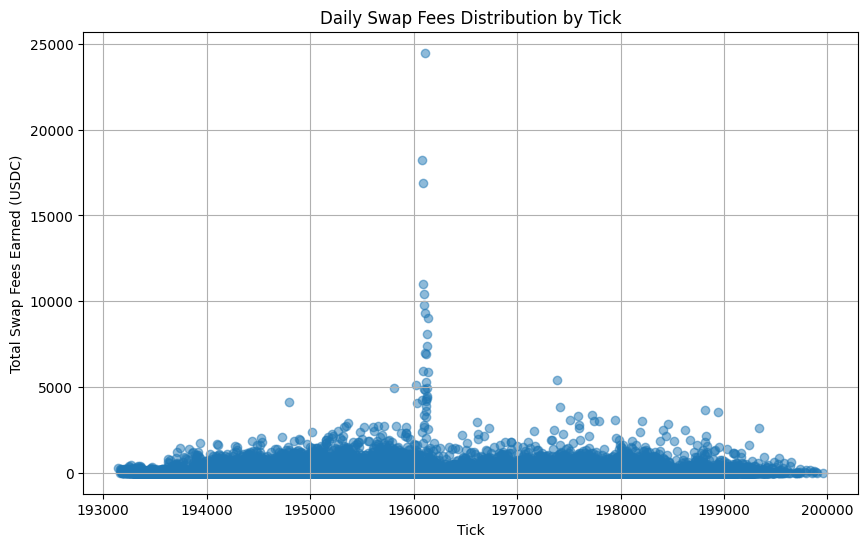

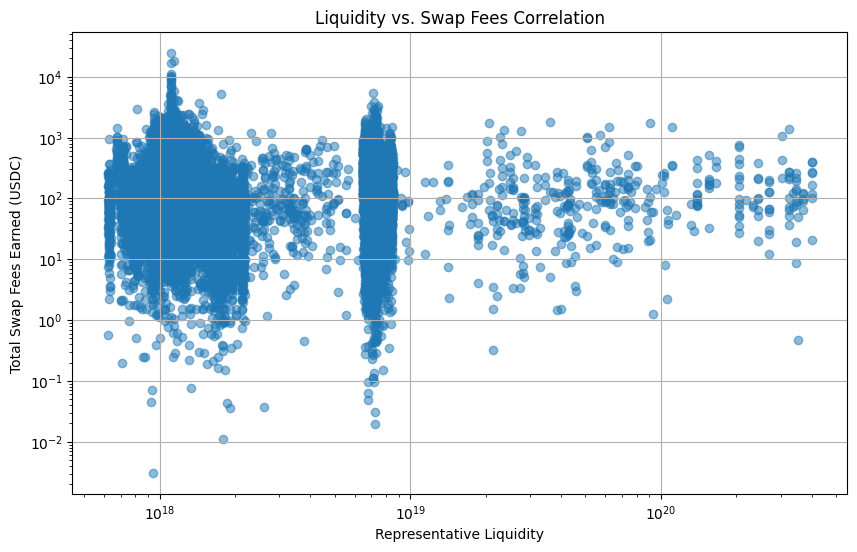

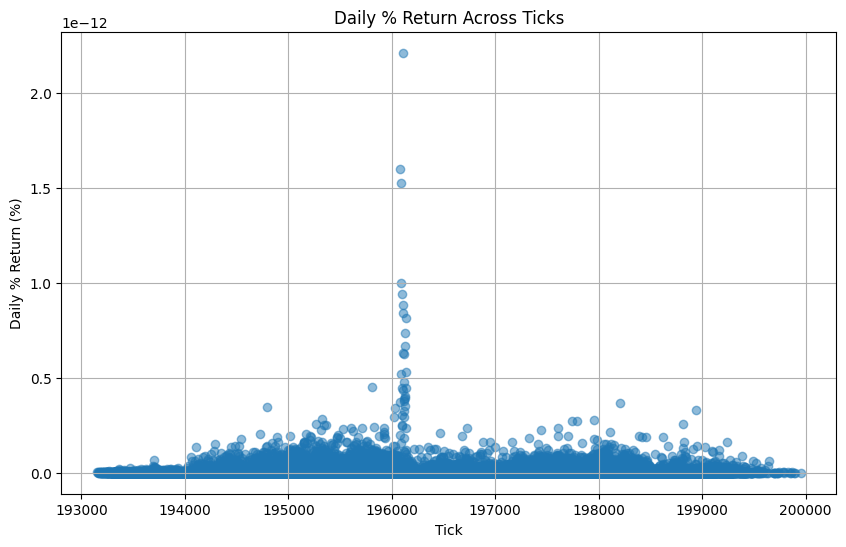

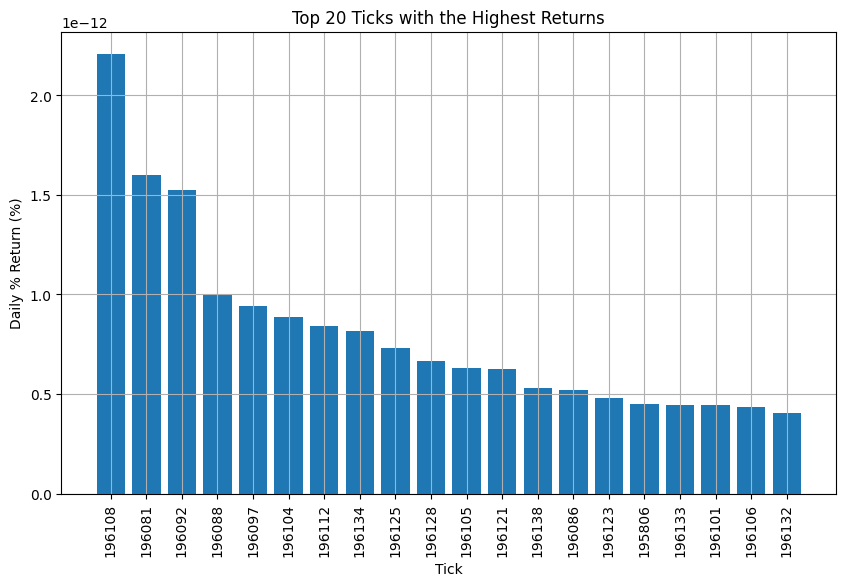

(20301, 5)

In [15]:
import matplotlib.pyplot as plt

# Plot 1: Daily Swap Fees Distribution by Tick
plt.figure(figsize=(10, 6))
plt.scatter(final_df["Tick"], final_df["Total Swap Fees Earned (USDC)"], alpha=0.5)
plt.xlabel("Tick")
plt.ylabel("Total Swap Fees Earned (USDC)")
plt.title("Daily Swap Fees Distribution by Tick")
plt.grid(True)
plt.show()

# Plot 2: Liquidity vs. Swap Fees Correlation
plt.figure(figsize=(10, 6))
plt.scatter(final_df["Representative Liquidity"], final_df["Total Swap Fees Earned (USDC)"], alpha=0.5)
plt.xlabel("Representative Liquidity")
plt.ylabel("Total Swap Fees Earned (USDC)")
plt.title("Liquidity vs. Swap Fees Correlation")
plt.xscale("log")  # Log scale to handle large liquidity values
plt.yscale("log")  # Log scale for better visualization
plt.grid(True)
plt.show()

# Plot 3: Daily % Return Across Ticks
plt.figure(figsize=(10, 6))
plt.scatter(final_df["Tick"], final_df["Daily % Return"], alpha=0.5)
plt.xlabel("Tick")
plt.ylabel("Daily % Return (%)")
plt.title("Daily % Return Across Ticks")
plt.grid(True)
plt.show()

# Plot 4: Tick Ranges with the Highest Returns
top_ticks = final_df.sort_values("Daily % Return", ascending=False).head(20)
plt.figure(figsize=(10, 6))
plt.bar(top_ticks["Tick"].astype(str), top_ticks["Daily % Return"])
plt.xlabel("Tick")
plt.ylabel("Daily % Return (%)")
plt.title("Top 20 Ticks with the Highest Returns")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Filter dataset to only include active ticks (where swap fees are greater than 0)
df_active_ticks = final_df[final_df["Total Swap Fees Earned (USDC)"] > 0]

# Display the updated DataFrame with only active ticks
df_active_ticks.head()
df_active_ticks.shape

In [16]:
df_active_ticks.to_csv('Active_ticks.csv')